## Random assignment, binary CATE example

This is a fully worked-out notebook showing how you would apply auto-causality to a dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy, auto-causality, and FLAML from source
root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

try:
    import flaml
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "FLAML"))


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from auto_causality import AutoCausality
from auto_causality.datasets import synth_ihdp
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the normalized ERUPT metric (chosen to specifically look for differences in impact across customers) on held-out data.

We import an example dataset and pre-process it. The pre-processing fills in the NaNs and one-hot-encodes all categorical and int variables.

If you don't want an int variable to be one-hot-encoded, please cast it to float before preprocessing.

In [5]:
data = synth_ihdp()
treatment = data.treatment
targets = data.outcomes
data_df, features_X, features_W = preprocess_dataset(data.data, treatment, targets)

outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)

In [6]:
print(train_df.head())

     treatment  y_factual        x1        x2        x3        x4        x5  \
274        0.0   3.442500  1.483860  1.795874 -1.105624  1.203011  0.183534   
667        1.0   5.894418 -0.029270 -0.202946  0.011465  0.161703 -0.754224   
475        0.0   1.036209  0.230124  0.596582  0.383828  0.161703 -0.816741   
79         1.0   7.834469  0.856992  1.795874  0.011465 -0.879606  0.558638   
705        0.0   2.354548 -0.461593  0.596582  0.011465 -0.879606  1.308844   

           x6   x7   x8  ...  x17  x18  x19  x20  x21  x22  x23  x24  x25  \
274  0.467138  0.0  0.0  ...  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
667 -0.360940  1.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
475 -1.023402  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
79   0.301522  0.0  1.0  ...  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
705  0.301522  0.0  1.0  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     random  
274     0.0  
667     1.0  
475     0.0  
79    

Fitting the model is as simple as calling AutoCausality.fit(), with the only required parameter apart from the data being the amount of time you want to give the optimizer, either for the whole run (`time_budget`) or per FLAML component model (`components_time_budget`), or both.

If you want to use specific estimators, comment in the `estimator_list` below to include any estimators whose full name contains any of the elements of `estimator_list`.

The other allowed values are `all` and `auto`, the default is `auto`.


In [20]:
ac = AutoCausality(
    time_budget=600,
#     estimator_list=[
#             "Dummy",
#             "SparseLinearDML",
#             "ForestDRLearner",
#             "TransformedOutcome",
#             "CausalForestDML",
#             ".LinearDML",
#             "DomainAdaptationLearner",
#             "SLearner",
#             "XLearner",
#             "TLearner",
#             "Ortho",
#         ],
    metric="norm_erupt",
    verbose=3,
    components_verbose=2,
    components_time_budget=60,
)


# run autocausality
ac.fit(train_df, treatment, outcome, features_W, features_X)

# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")


[I 2022-07-12 14:37:59,634] A new study created in memory with name: optuna
[flaml.tune.tune: 07-12 14:37:59] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}, {'estimator': {'estimat

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[flaml.tune.tune: 07-12 14:38:08] {110} INFO - result: {'norm_erupt': 2.650617967283021, 'estimator_name': 'backdoor.auto_causality.models.Dummy', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x13cdd4460>, 'ate': 4.073783874511719, 'erupt': 6.453920882323696, 'norm_erupt': 2.30059126902885, 'qini': 0.012247429231311885, 'auc': 0.5072093144169901, 'values':      treated  y_factual        p  policy  norm_policy   weights
0        0.0   1.797997  0.18239    True         True  0.000000
1        1.0   6.886719  0.18239    True         True  5.482759
2        0.0   2.560395  0.18239    True         True  0.000000
3        0.0   7.045186  0.18239    True        False  0.000000
4        0.0   2.945608  0.18239    True         True  0.000000
..       ...        ...      ...     ...          ...       ...
472      0.0   4.279700  0.18239    

{'estimator_name': 'backdoor.econml.metalearners.SLearner'}


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[flaml.tune.tune: 07-12 14:39:19] {110} INFO - result: {'norm_erupt': 3.335819900035857, 'estimator_name': 'backdoor.econml.metalearners.SLearner', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x13cc7c910>, 'ate': 4.073783874511719, 'erupt': 6.474469981968939, 'norm_erupt': 2.7803435060733417, 'qini': 0.057594985757655794, 'auc': 0.5727713776183203, 'values':      treated  y_factual        p  policy  norm_policy   weights
0        0.0   1.797997  0.18239    True        False  0.000000
1        1.0   6.886719  0.18239    True         True  5.427096
2        0.0   2.560395  0.18239    True        False  0.000000
3        0.0   7.045186  0.18239    True        False  0.000000
4        0.0   2.945608  0.18239    True        False  0.000000
..       ...        ...      ...     ...          ...       ...
472      0.0   4.279700  0.18239 

{'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}


Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

{'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a Dat

{'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}


[flaml.tune.tune: 07-12 14:46:21] {110} INFO - result: {'norm_erupt': 3.2108058099235794, 'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x13de660d0>, 'ate': 4.073783874511719, 'erupt': 6.453920882323696, 'norm_erupt': 2.7939770783182967, 'qini': 0.06958598214115391, 'auc': 0.5723682731743217, 'values':      treated  y_factual        p  policy  norm_policy   weights
0        0.0   1.797997  0.18239    True        False  0.000000
1        1.0   6.886719  0.18239    True         True  5.482759
2        0.0   2.560395  0.18239    True        False  0.000000
3        0.0   7.045186  0.18239    True        False  0.000000
4        0.0   2.945608  0.18239    True        False  0.000000
..       ...        ...      ...     ...          ...       ...
472      0.0   4.279700  0.18239    True        False  0.000000
473      0.0   3.364810  0.18239    True        False  0.000000
474 

{'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome'}


[flaml.tune.tune: 07-12 14:47:22] {110} INFO - result: {'norm_erupt': 3.024716540279551, 'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x13e5e9580>, 'ate': 4.073783874511719, 'erupt': 5.889537780297243, 'norm_erupt': 2.7507172363400008, 'qini': 0.18552022521504227, 'auc': 0.4977098857331332, 'values':      treated  y_factual        p  policy  norm_policy   weights
0        0.0   1.797997  0.18239   False        False  1.077924
1        1.0   6.886719  0.18239    True        False  4.832074
2        0.0   2.560395  0.18239    True        False  0.000000
3        0.0   7.045186  0.18239    True        False  0.000000
4        0.0   2.945608  0.18239    True         True  0.000000
..       ...        ...      ...     ...          ...       ...
472      0.0   4.279700  0.18239    True        False  0.000000
473      0.0   3.364810  0.18239    True        False  

{'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 0.0017231790528715186, 'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.18432972513405987, 'max_features': 'log2', 'min_impurity_decrease': 2.6639242043080236, 'max_samples': 0.378105341302808, 'min_balancedness_tol': 0.006805783323944936, 'honest': 1, 'subforest_size': 8}


[flaml.tune.tune: 07-12 14:49:23] {110} INFO - result: {'norm_erupt': 2.766067934036255, 'estimator': <dowhy.causal_estimator.CausalEstimate object at 0x13e80e0a0>, 'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x13e1ab4f0>, 'ate': 4.073783874511719, 'erupt': 6.453920882323696, 'norm_erupt': 2.3801375331548256, 'qini': 0.007262495960302207, 'auc': 0.5048552955473048, 'values':      treated  y_factual        p  policy  norm_policy   weights
0        0.0   1.797997  0.18239    True        False  0.000000
1        1.0   6.886719  0.18239    True        False  5.482759
2        0.0   2.560395  0.18239    True        False  0.000000
3        0.0   7.045186  0.18239    True        False  0.000000
4        0.0   2.945608  0.18239    True        False  0.000000
..       ...        ...      ...     ...          ...       ...
472      0.0   4.279700  0.18239    True        False  0.

Best estimator: backdoor.econml.metalearners.SLearner
best config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
best score: 3.335819900035857


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

config: {'estimator_name': 'backdoor.econml.metalearners.SLearner'}
config: {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}
config: {'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome'}
config: {'estimator_name': 'backdoor.auto_causality.models.Dummy'}
config: {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}
config: {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}
config: {'est

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

After running a fit, you can resume it without losing past results, for example if you want to search over extra estimators.

In [7]:
# we can now resume the fit to continue with the init_cfgs which we haven't tried yet
# ac.fit(train_df, treatment, outcome, features_W, features_X,resume=True)
# # return best estimator
# print(f"Best estimator: {ac.best_estimator}")
# # config of best estimator:
# print(f"best config: {ac.best_config}")
# # best score:
# print(f"best score: {ac.best_score}")

In [8]:
# ac.results.results

In [22]:
# score all estimators on the test set, which we've kept aside up till now
for est_name, scr in ac.scores.items():
    causal_estimate = scr['estimator']
    scr['scores']['test'] = Scorer.make_scores(causal_estimate, test_df, ac.propensity_model, problem=ac.problem, metrics_to_report=ac.metrics_to_report)

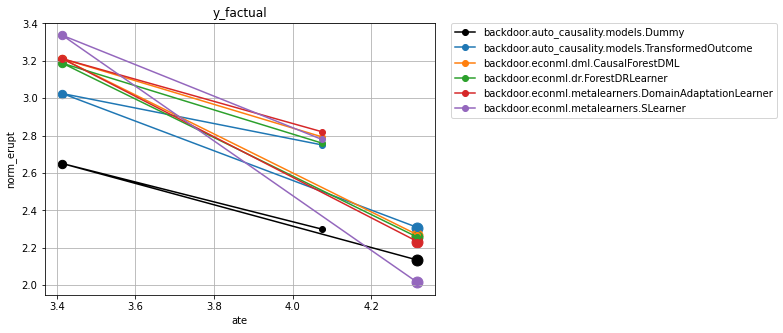

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "ate"
m2 = "norm_erupt"

for (est, scr), col in zip(ac.scores.items(),colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        crv = [scr["scores"]['train'][m2], scr["scores"]['validation'][m2], scr["scores"]['test'][m2]]
        plt.plot(sc, crv, color=col, marker="o", label=est)
        plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
        plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

    except:
        pass
plt.xlabel(m1)
plt.ylabel(m2)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


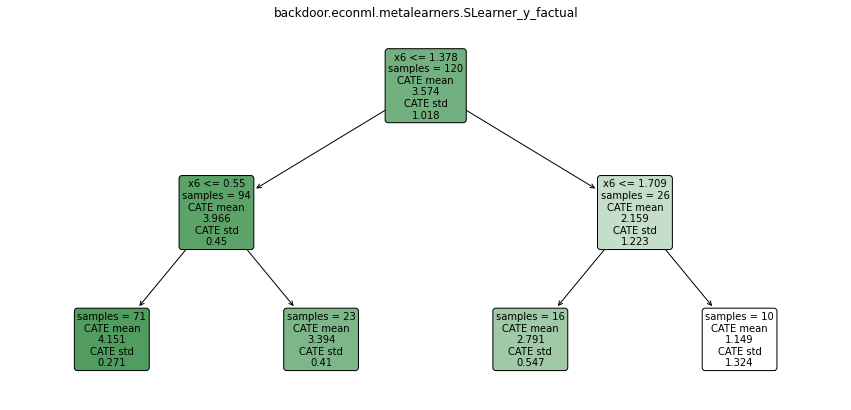

In [24]:
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()


y_factual backdoor.econml.metalearners.SLearner


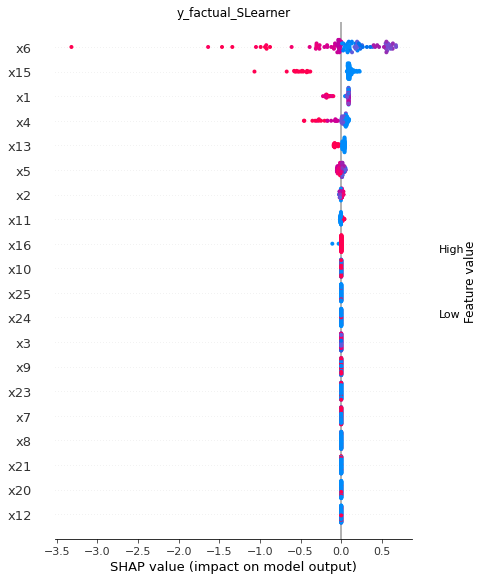

In [25]:
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

scr = ac.scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()


,policy,mean,std,count
0,all,4.317822,0.237790,150
1,False,4.255104,0.253968,128
2,True,4.478226,1.032754,22


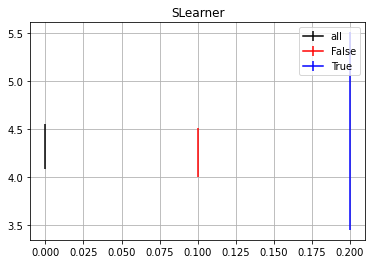

In [19]:
# plot out-of sample difference of outcomes between treated and untreated for the points where a model predicts positive vs negative impact
my_est = ac.best_estimator
stats = []

v = ac.scores[my_est]['scores']['test']['values']

sts = Scorer.group_ate(v['treated'], v[outcome], v['norm_policy'])

display(sts)


colors = (matplotlib.colors.CSS4_COLORS['black'],
    matplotlib.colors.CSS4_COLORS['red'],
    matplotlib.colors.CSS4_COLORS['blue'])

grp = sts["policy"].unique()

for i,(p,c) in enumerate(zip(grp, colors)):
    st = sts[sts["policy"] == p]
    plt.errorbar(np.array(range(len(st))) +0.1*i, st["mean"].values[0],  yerr = st["std"].values[0], color=c)
plt.legend(grp)
plt.grid(True)
plt.title(my_est.split('.')[-1])
plt.show()